In [1]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from skimage import data
import sknw
import networkx as nx


In [3]:
# zig zag definitions
def drawline(p1,p2,image):
    p1 = tuple(p1.astype(int).tolist()) #input is numpyfloat array
    p2 = tuple(p2.astype(int).tolist()) # cv2.line needs tuple int inputs 
    color = (255, 255, 255) # color in BGR
    thickness = 1 # line thickness  

    #AND THEN FLIP THE  Y , X  FORMAT TO GRAPH IT CORRECTLY !!!!!! 
    start_point  = [p1[1],p1[0]]
    end_point = [p2[1],p2[0]]

    return(cv2.line(image, start_point, end_point, color, thickness))

def open_image(path):
    try: 
        image = cv2.imread(path, 0) # Reading an image in grayscale mode
        print("found image at : " , path)
    except:
        print("couldn't find image at : ", path)
    return(image)

def show_image(image):
    plt.imshow(image, cmap='gray') #map the image to black and white, white representing the line 
    plt.show()
    print("Plotted")

def zigzag(start_point,end_point,num_turns,zig_zag_size,image): #zigzagsize will scale the size of the zig zags
    
    #num turns must be greater than 2 
    slope_vector = np.array([  end_point[0]- start_point[0] , end_point[1] - start_point[1] ]) # vector representation of slope here in format [y , x]
    step_vector = slope_vector / (num_turns - 1) # partition total change inslope into steps to zig zag across and -1 because the number of turns will be one less than the number of partitions (also in format [y , x])
    normalized_step_vector = step_vector/np.linalg.norm(step_vector) # here we are getting the normalized step_vector so we can use its direction and ignore its magnitude 
    zig_zag_size_vector = normalized_step_vector * zig_zag_size

    for i in range(0,num_turns): 
        

        # ctrl / to toggle commented areas 
        # if i%2 ==0: # set zig and zag values (with alternating directions)
        #     zigzag = zig_zag_size_vector * np.array([1,-1])
        # else:
        #     zigzag =  zig_zag_size_vector * np.array([-1,1])

        if i%2 ==0: # set zig and zag values (with alternating directions)
            zigzag = [-zig_zag_size_vector[1], zig_zag_size_vector[0]]
        else:
            zigzag = [zig_zag_size_vector[1], -zig_zag_size_vector[0]]

        if i == 0: #if i is start point
            pt1 = start_point + step_vector*(i)
            pt2 = start_point + step_vector*(i+1) + zigzag
            try : image = drawline(pt1,pt2,image)
            except : print("error zigging")
            pt_old = pt2 #save endpoint
        elif i == num_turns-1: #elif i+1 is FINAL endpoint
            pt1 = pt_old
            pt2 = start_point + step_vector*(i) 
            try : image = drawline(pt1,pt2,image)
            except : print("error zagging")
        else: #otherwise in the middle 
            pt1 = pt_old
            pt2 = start_point + step_vector*(i+1) +zigzag
            try : image = drawline(pt1,pt2,image)
            except : print("error zig-zagging")
            pt_old =pt2 #save endpoint for next start  
    #image = drawline(start_point,end_point,image) #this is just for error checking, draw a line between start and end points 
    #show_image(image)
    return(image)

In [4]:
#skeleton to graph definition

def skeleton_to_graph(path):
    try: img = cv2.imread(cv2.samples.findFile(path),0) # get img
    except : print("can't find that image at", path)
    img = (255-img) 
    img = img > 127 #make bool 
    ske = skeletonize(~img).astype(np.uint16) # use sknw skeletonize # ------------------------ this skeletonizes!!!
    graph = sknw.build_sknw(ske) # build graph from skeleton
    print("\nskeleton converted to graph\n")
    return graph


In [5]:

def locate_nodes(path_to_image):
#read 3D rbg image as 2D greyscale nparray
    print("be sure you are pathing to a skeleton for locate_nodes")
    blobs = cv2.imread(cv2.samples.findFile(path_to_image),0) 
    # last parameter 0 = greyscale 1 = color -1 = unchanged 

    #convert data from int to np bool 
    blobs = blobs > 127 
    #blobs is now a (540,960) 2 D array

    print("(ydim , xdim) == ",blobs.shape)

    ydim = blobs.shape[0] #num rows 540
    xdim = blobs.shape[1] #num columns 960


    # measure some skeleton metrics down here 
    sum_local_neighbors = 0 #number of adjacent skeleton pixels 
    sum_num_nodes = 0 #total number pixels that are of nodes of the skeleton
    sum_num_edges = 0 #total number pixels that are of edges ots 
    sum_num_endpoints = 0 #total number of pixels that are end points of the skeleton
    sum_num_islands = 0 #total number of pixels that are isolated
    sum_points_length = 0 #total number of skeleton pixels aka length of skeleton

    total_num_edgelines = 0 #how many actual edges are there in the network

    #lets make a bunch of arrays storing : node locations, endpoint locations, edge locations,island locations  
    node_locations = []
    edge_locations = []
    endpoint_locations = []
    island_locations = []

    total_skeleton = []
    #here we are going to find the nodes and edges and endpoints

    for row in range(0,ydim): #iterate through rows 
        for col in range(0,xdim): #iterate through columns
            
            if blobs[row][col] == True: #if pixel is skeleton add 1 to length of skeleton
                sum_points_length +=1
                
                #find the sum of the local neighbors included in the skeleton (including self): 1 = solo ,2= endpoint, 3 = edge , 4+ = node 
                for i in range(-1,2):
                    for j in range(-1,2):
                        try: #this because there may be points on the edge of the picture
                            sum_local_neighbors += int(blobs[row +i][col +j])
                        except:
                            pass
                
                #HEY JUST SO YOU KNOW: here I switch formats from (y,x) to (x,y) just to make things more confusing 
                 
                #figure out num nodes endpoints and edges
                if sum_local_neighbors >= 4: #if node
                    node_locations.append([col,row])
                    sum_num_nodes += 1
                    total_num_edgelines += sum_local_neighbors -1 #count connection points (-1 to remove self counting)
                elif sum_local_neighbors == 3: # if edge
                    edge_locations.append([col,row])
                    sum_num_edges += 1
                elif sum_local_neighbors == 2: # if endpoint
                    endpoint_locations.append([col,row])
                    sum_num_endpoints += 1
                    total_num_edgelines += sum_local_neighbors -1 #count connection points (-1 to remove self counting)
                else: #if island 
                    island_locations.append([col,row])
                    print("isolated point at (x,y)", col, row)
                    sum_num_islands +=1
                total_skeleton.append([col,row])
                #reset counter     
                sum_local_neighbors = 0

    #error check
    if sum_num_nodes + sum_num_edges + sum_num_endpoints + sum_num_islands == sum_points_length & len(total_skeleton) == sum_points_length:
        print("No errors detected")
    else:
        print("f*&!")

    total_num_edgelines = total_num_edgelines / 2 #because each edge has two endpoints 
    print("this skeleton has {0} edge lines, {1} nodes, {2} endpoints, and {3} islands. \nthe skeleton is of length {4} pixels.".format(total_num_edgelines , sum_num_nodes, sum_num_endpoints, sum_num_islands, sum_points_length))

    print("the edgelines are of average length {0}, .".format( sum_num_edges / total_num_edgelines))

    print("this function returns total_skeleton, nodes, edges, endpoints, and island's locations in (x,y) coordinate form")
    return total_skeleton,node_locations,edge_locations,endpoint_locations,island_locations

In [6]:

path = r'../MAPS/Lake_Murray_Map_Skeletons/e_d_murray_skeleton.png' 
graph = skeleton_to_graph(path)
image = open_image(path) #start by opening the image, choose image in the function 





skeleton converted to graph

found image at :  ../MAPS/Lake_Murray_Map_Skeletons/e_d_murray_skeleton.png


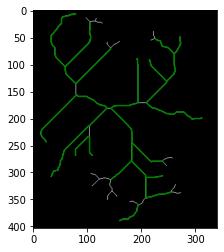

In [7]:

# draw image
plt.imshow(image, cmap='gray')
for (s,e) in graph.edges():
    if graph[s][e]['weight'] > 30: # ------------------------------------------------- this is to make the small edges not apply 
        ps = graph[s][e]['pts']
        plt.plot(ps[:,1], ps[:,0], 'green')


{'pts': array([[ 14,  98],
       [ 15,  99],
       [ 16, 100],
       [ 17, 101],
       [ 18, 102],
       [ 19, 103],
       [ 20, 104],
       [ 21, 105]], dtype=int16), 'weight': 9.899494936611667}
{'pts': array([[ 15, 117],
       [ 16, 116],
       [ 17, 116],
       [ 18, 116],
       [ 19, 115]], dtype=int16), 'weight': 4.82842712474619}
{'pts': array([[ 20, 114],
       [ 20, 113],
       [ 20, 112],
       [ 20, 111],
       [ 20, 110],
       [ 21, 109],
       [ 21, 108],
       [ 21, 107],
       [ 21, 106]], dtype=int16), 'weight': 8.414213562373096}
{'pts': array([[ 20, 115],
       [ 21, 116],
       [ 21, 117],
       [ 21, 118],
       [ 22, 119],
       [ 22, 120],
       [ 22, 121],
       [ 22, 122],
       [ 22, 123],
       [ 22, 124],
       [ 22, 125],
       [ 23, 126],
       [ 23, 127],
       [ 24, 128]], dtype=int16), 'weight': 14.656854249492381}
{'pts': array([[ 39, 223],
       [ 40, 223],
       [ 41, 223],
       [ 42, 223],
       [ 43, 223],
     

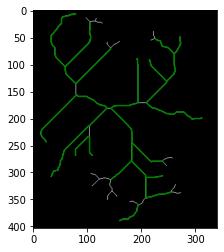

In [8]:
# draw image
plt.imshow(image, cmap='gray')
for (s,e) in graph.edges():
    if graph[s][e]['weight'] > 30 : # ------------------------------------------------- this is to make the small edges not apply 
        ps = graph[s][e]['pts']
        plt.plot(ps[:,1], ps[:,0], 'green')
    else :
        print( graph[s][e] )





In [9]:
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])

print(ps)



[[  6.          78.        ]
 [ 14.          98.        ]
 [ 15.         117.        ]
 [ 19.66666667 114.66666667]
 [ 21.33333333 105.33333333]
 [ 24.         128.        ]
 [ 39.         223.        ]
 [ 49.         272.        ]
 [ 51.75       225.        ]
 [ 55.         218.        ]
 [ 58.         160.        ]
 [ 59.         137.        ]
 [ 69.33333333 143.33333333]
 [ 80.         261.        ]
 [ 89.         193.        ]
 [ 91.         215.        ]
 [104.          59.        ]
 [131.         247.        ]
 [135.33333333  78.66666667]
 [156.75        80.        ]
 [170.75       194.        ]
 [170.66666667 209.66666667]
 [180.66666667 136.33333333]
 [181.         144.        ]
 [199.         312.        ]
 [214.33333333 103.66666667]
 [233.         103.75      ]
 [243.          23.        ]
 [245.         182.5       ]
 [268.          78.        ]
 [268.         109.        ]
 [273.         258.        ]
 [278.66666667 181.66666667]
 [279.         239.        ]
 [287.        


skeleton converted to graph

found image at :  ../MAPS/Lake_Murray_Map_Skeletons/e_d_murray_skeleton.png
117 [33, 47]
8 [102, 18]
5 [116, 18]
9 [109, 21]
14 [122, 22]
83 [99, 64]
13 [223, 46]
32 [271, 65]
7 [220, 54]
42 [241, 67]
17 [151, 63]
11 [139, 65]
66 [111, 103]
52 [262, 106]
82 [194, 130]
41 [228, 112]
32 [63, 120]
40 [229, 151]
21 [79, 147]
87 [35, 201]
56 [109, 165]
50 [168, 176]
15 [203, 171]
103 [262, 191]
34 [119, 198]
8 [141, 181]
64 [176, 213]
101 [56, 264]
18 [104, 224]
37 [84, 251]
35 [104, 252]
57 [212, 274]
33 [182, 263]
20 [248, 273]
39 [161, 299]
30 [197, 294]
9 [244, 284]
16 [115, 304]
31 [223, 309]
37 [208, 329]
14 [115, 319]
20 [133, 310]
21 [143, 325]
14 [260, 329]
16 [138, 343]
10 [152, 340]
46 [231, 341]
18 [265, 338]
17 [202, 356]
17 [188, 355]
47 [181, 382]


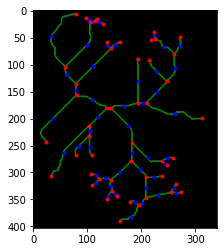

In [10]:
#FIND MIDPOINT
graph = skeleton_to_graph(path)
image = open_image(path) #start by opening the image, choose image in the function 

# draw image
plt.imshow(image, cmap='gray')

for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')

#  ----------------------------------get and plot mid point here 
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    
    #print(len(ps))
    if len(ps)%2 == 0:
        midpoint = [ ps[int(len(ps)/2),1] , ps[int(len(ps)/2),0] ]
        #print(int(len(ps)/2))
    else:
        midpoint = [ ps[int((len(ps)+1) /2),1] , ps[int((len(ps)+1) /2),0] ]
        #print(int((len(ps)+1) /2))
    print(len(ps),midpoint)
    plt.plot(midpoint[0], midpoint[1], 'b.')

#------------------------------------- finished

# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.') # ps[0,1], ps[0,0] = x , y coordinates
# plt.savefig('skel_network_and_nodes.png')


In [11]:
path = r'../MAPS/Lake_Murray_Map_Skeletons/e_d_murray_skeleton.png' 
total_skeleton,node_locations,edge_locations,endpoint_locations,island_locations = locate_nodes(path)

be sure you are pathing to a skeleton for locate_nodes
(ydim , xdim) ==  (403, 341)
No errors detected
this skeleton has 126.0 edge lines, 72 nodes, 27 endpoints, and 0 islands. 
the skeleton is of length 1809 pixels.
the edgelines are of average length 13.571428571428571, .
this function returns total_skeleton, nodes, edges, endpoints, and island's locations in (x,y) coordinate form


In [12]:
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    start = [ ps[0,1],ps[0,0] ]
    end = [ ps[-1,1],ps[-1,0] ]
    print(start,end)
    print(type(start))
    # if graph[s][e]['weight'] < 30 & ( ([ps[0,1],ps[0,0]] in endpoint_locations) or ([ps[-1,1],ps[-1,0]] in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
    if graph[s][e]['weight'] < 30 & ( (start in endpoint_locations) or (end in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
        print('edge found to be trimmed')  
        if ([ps[0,1],ps[0,0]] in endpoint_locations) or ([ps[-1,1],ps[-1,0]] in endpoint_locations) :
            print('endpoint match')

        
        #plt.plot(ps[:,1], ps[:,0], 'green')

    else:
        print("no matches")

[78, 6] [59, 104]
<class 'list'>
no matches
[98, 14] [105, 21]
<class 'list'>
no matches
[117, 15] [115, 19]
<class 'list'>
no matches
[114, 20] [106, 21]
<class 'list'>
no matches
[115, 20] [128, 24]
<class 'list'>
no matches
[105, 22] [59, 104]
<class 'list'>
no matches
[223, 39] [225, 51]
<class 'list'>
no matches
[272, 49] [261, 80]
<class 'list'>
no matches
[224, 52] [218, 55]
<class 'list'>
no matches
[226, 52] [261, 80]
<class 'list'>
no matches
[160, 58] [144, 69]
<class 'list'>
no matches
[137, 59] [143, 69]
<class 'list'>
no matches
[143, 70] [79, 135]
<class 'list'>
no matches
[261, 80] [247, 131]
<class 'list'>
no matches
[193, 89] [194, 170]
<class 'list'>
no matches
[215, 91] [247, 131]
<class 'list'>
no matches
[59, 104] [78, 135]
<class 'list'>
no matches
[247, 131] [210, 170]
<class 'list'>
no matches
[79, 136] [80, 156]
<class 'list'>
no matches
[79, 157] [23, 243]
<class 'list'>
no matches
[81, 157] [136, 180]
<class 'list'>
no matches
[193, 171] [144, 181]
<class 'l

In [13]:
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    start = [ ps[0,1],ps[0,0] ]
    end = [ ps[-1,1],ps[-1,0] ]
    # print(ps[0,1],ps[0,0], "    ", ps[-1,1],ps[-1,0])
    print(start, "    ", end)
    print(node_locations)


]      [104, 232]
[[115, 19], [114, 20], [115, 20], [105, 21], [106, 21], [105, 22], [225, 51], [224, 52], [225, 52], [226, 52], [143, 69], [144, 69], [143, 70], [261, 80], [59, 104], [247, 131], [78, 135], [79, 135], [79, 136], [80, 156], [79, 157], [80, 157], [81, 157], [194, 170], [210, 170], [193, 171], [194, 171], [195, 171], [209, 171], [210, 171], [136, 180], [136, 181], [137, 181], [144, 181], [103, 214], [104, 214], [104, 215], [104, 232], [103, 233], [104, 233], [104, 234], [183, 244], [182, 245], [183, 245], [182, 246], [182, 278], [181, 279], [182, 279], [239, 279], [208, 308], [208, 309], [209, 309], [208, 310], [122, 311], [122, 312], [123, 312], [142, 313], [143, 313], [144, 313], [143, 314], [146, 334], [145, 335], [146, 335], [147, 335], [255, 335], [254, 336], [255, 336], [256, 336], [208, 346], [208, 347], [209, 347], [195, 360]]
[103, 233]      [78, 268]
[[115, 19], [114, 20], [115, 20], [105, 21], [106, 21], [105, 22], [225, 51], [224, 52], [225, 52], [226, 52], [1

In [14]:
print(endpoint_locations)

[[78, 6], [98, 14], [117, 15], [128, 24], [223, 39], [272, 49], [218, 55], [160, 58], [137, 59], [193, 89], [215, 91], [312, 199], [23, 243], [78, 268], [109, 268], [258, 273], [247, 287], [107, 302], [239, 306], [33, 307], [264, 322], [109, 324], [273, 337], [155, 344], [137, 350], [179, 354], [160, 389]]


In [15]:
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    start = [ ps[0,1],ps[0,0] ]
    end = [ ps[-1,1],ps[-1,0] ]
    print(start,end)
    print(type(start))
    # if graph[s][e]['weight'] < 30 & ( ([ps[0,1],ps[0,0]] in endpoint_locations) or ([ps[-1,1],ps[-1,0]] in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
    if ( (start in endpoint_locations) or (end in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
        print('edge found')  
        if graph[s][e]['weight'] < 30:
            print('trim this one')
        else:
            print('nah leave em be')
    else:
        print("no matches")

[78, 6] [59, 104]
<class 'list'>
edge found
nah leave em be
[98, 14] [105, 21]
<class 'list'>
edge found
trim this one
[117, 15] [115, 19]
<class 'list'>
edge found
trim this one
[114, 20] [106, 21]
<class 'list'>
no matches
[115, 20] [128, 24]
<class 'list'>
edge found
trim this one
[105, 22] [59, 104]
<class 'list'>
no matches
[223, 39] [225, 51]
<class 'list'>
edge found
trim this one
[272, 49] [261, 80]
<class 'list'>
edge found
nah leave em be
[224, 52] [218, 55]
<class 'list'>
edge found
trim this one
[226, 52] [261, 80]
<class 'list'>
no matches
[160, 58] [144, 69]
<class 'list'>
edge found
trim this one
[137, 59] [143, 69]
<class 'list'>
edge found
trim this one
[143, 70] [79, 135]
<class 'list'>
no matches
[261, 80] [247, 131]
<class 'list'>
no matches
[193, 89] [194, 170]
<class 'list'>
edge found
nah leave em be
[215, 91] [247, 131]
<class 'list'>
edge found
nah leave em be
[59, 104] [78, 135]
<class 'list'>
no matches
[247, 131] [210, 170]
<class 'list'>
no matches
[79, 136

In [16]:
 # ok now you can remove the necessary edges from the 'graph'

 # then convert the graph back to an image

 # check that the number of midpoints = num edges 

 #but first talk to nare ask her if what you are doing overall is fruitful

 #show the voronoi diagram on the long edges and how it does not bound the edge well as we thought that it would 

# TUESDAY
 # also see if you can clean up the erronious midpoints / voronoi partitions 

#  find skeleton of the skeleton (edges equidistant from the skeletal edges )